#### Glimmer using cnn-lstm architecture (6 features, trying to achieve paper )

In [1]:
import sys, tensorflow as tf
print(sys.executable)
print(tf.config.list_physical_devices("GPU"))

D:\CondaEnvironment\azka_tf_gpu_env\python.exe
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
import numpy as np
print(np.__version__)

1.23.5


In [3]:
#pip install -r requirements.txt

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
#################################Training#################################
!python mainPersonalized-cnn_lstm.py

The summaraize results of personalized models


Loaded metrics for 25 patients.

Overall numeric metrics across all patients:

        RMSE_total  MAE_total  MAPE_total
mean     30.114911  23.077019    0.173557
median   28.015456  21.157291    0.166278
std       6.750935   5.830225    0.037951

Overall Clarke Error Zones across all patients (% of points in each zone):

                A           B     C          D     E
mean  1865.640000  437.000000  0.04  28.520000  0.16
std    440.568182  198.512384  0.20  23.223767  0.80


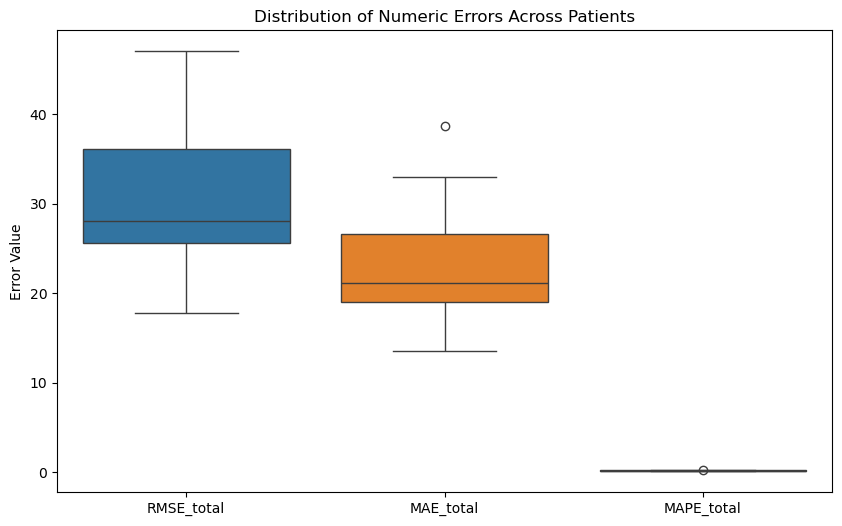

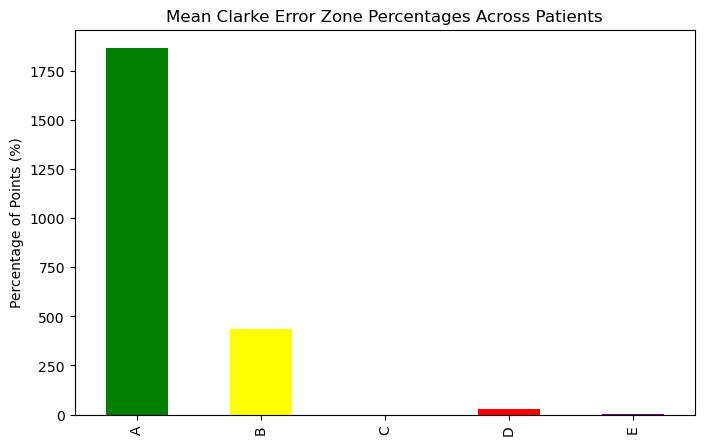


Overall numeric summary saved to D:\JupyterNotebooks\Azka\Trying to achieve the papers accuracy\GLIMMER Personalzied model\glimmer_cnn_lstm_results\overall_numeric_summary.csv
Overall Clarke summary saved to D:\JupyterNotebooks\Azka\Trying to achieve the papers accuracy\GLIMMER Personalzied model\glimmer_cnn_lstm_results\overall_clarke_summary.csv


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths
# -----------------------------
out_dir = r"D:\JupyterNotebooks\Azka\Trying to achieve the papers accuracy\GLIMMER Personalzied model\glimmer_cnn_lstm_results"
main_csv_path = os.path.join(out_dir, "main.csv")

# -----------------------------
# Load numeric metrics
# -----------------------------
df_metrics = pd.read_csv(main_csv_path)
print(f"Loaded metrics for {len(df_metrics)} patients.")

metrics = ['RMSE_total', 'MAE_total', 'MAPE_total']

numeric_summary = df_metrics[metrics].agg(['mean','median','std'])
print("\nOverall numeric metrics across all patients:\n")
print(numeric_summary)

# -----------------------------
# Aggregate Clarke Error Zones
# -----------------------------
clarke_zones_list = []

for patient_id in df_metrics['PatientID']:
    patient_dir = os.path.join(out_dir, patient_id, "errors")
    clarke_file = os.path.join(patient_dir, "clarke_zones.csv")
    if os.path.exists(clarke_file):
        df_zone = pd.read_csv(clarke_file)
        clarke_zones_list.append(df_zone.iloc[0])  # single row per patient
    else:
        print(f"[WARNING] Clarke file not found for {patient_id}")

# Combine all patient zones
df_clarke = pd.DataFrame(clarke_zones_list)

# Compute mean & std for each zone
clarke_summary = df_clarke.agg(['mean','std'])
print("\nOverall Clarke Error Zones across all patients (% of points in each zone):\n")
print(clarke_summary)

# -----------------------------
# Optional: Boxplot of errors
# -----------------------------
plt.figure(figsize=(10,6))
sns.boxplot(data=df_metrics[metrics])
plt.title("Distribution of Numeric Errors Across Patients")
plt.ylabel("Error Value")
plt.show()

# -----------------------------
# Optional: Bar chart of mean Clarke zones
# -----------------------------
plt.figure(figsize=(8,5))
clarke_summary.loc['mean'].plot(kind='bar', color=['green','yellow','orange','red','purple'])
plt.title("Mean Clarke Error Zone Percentages Across Patients")
plt.ylabel("Percentage of Points (%)")
plt.show()

# -----------------------------
# Save summaries
# -----------------------------
numeric_summary.to_csv(os.path.join(out_dir, "overall_numeric_summary.csv"))
clarke_summary.to_csv(os.path.join(out_dir, "overall_clarke_summary.csv"))
print(f"\nOverall numeric summary saved to {os.path.join(out_dir, 'overall_numeric_summary.csv')}")
print(f"Overall Clarke summary saved to {os.path.join(out_dir, 'overall_clarke_summary.csv')}")


Bars turn red if Clarke A+B < 90% → immediate visual warning.

Green line shows actual Clarke A+B percentage.

Red dashed line marks 90% threshold, the clinical safety target.

Goal: RMSE & MAE low, Clarke A+B ≥ 90%.

Patients falling below 90% are flagged in red for review.

In [1]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"  # or "notebook" if old version

In [8]:
import os
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# -----------------------------
# Paths
# -----------------------------
out_dir = "./glimmer_cnn_lstm_results"  # folder containing patient folders
main_csv_path = os.path.join(out_dir, "main.csv")

# -----------------------------
# Load numeric metrics
# -----------------------------
df_metrics = pd.read_csv(main_csv_path)
patients = df_metrics['PatientID'].tolist()

# -----------------------------
# Load Clarke zones per patient and compute A+B %
# -----------------------------
clarke_a_b_perc = []

for pid in patients:
    clarke_file = os.path.join(out_dir, pid, "errors", "clarke_zones.csv")
    if os.path.exists(clarke_file):
        df_zone = pd.read_csv(clarke_file)
        total = df_zone[['A','B','C','D','E']].sum(axis=1).values[0]
        a_b_perc = (df_zone['A'].values[0] + df_zone['B'].values[0]) / total * 100
        clarke_a_b_perc.append(a_b_perc)
    else:
        clarke_a_b_perc.append(0)

df_metrics['Clarke_A+B_%'] = clarke_a_b_perc

# -----------------------------
# Prepare figure
# -----------------------------
fig = go.Figure()

# RMSE bars
fig.add_trace(go.Bar(
    x=patients,
    y=df_metrics['RMSE_total'],
    name='RMSE',
    marker_color='salmon',
    yaxis='y1'
))

# MAE bars
fig.add_trace(go.Bar(
    x=patients,
    y=df_metrics['MAE_total'],
    name='MAE',
    marker_color='skyblue',
    yaxis='y1'
))

# Clarke A+B % line
fig.add_trace(go.Scatter(
    x=patients,
    y=df_metrics['Clarke_A+B_%'],
    mode='lines+markers',
    name='Clarke A+B %',
    line=dict(color='green', width=3),
    marker=dict(size=8),
    yaxis='y2'
))

# -----------------------------
# Layout with dual y-axis
# -----------------------------
fig.update_layout(
    title="Personalized Model Results Across Patients",
    xaxis_title="Patient ID",
    yaxis=dict(
        title="Error (mg/dL)",
        side="left",
        showgrid=True,
        zeroline=True,
        range=[0, max(df_metrics[['RMSE_total','MAE_total']].max().max()*1.1, 100)]
    ),
    yaxis2=dict(
        title="% of Points in Clarke A+B",
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    barmode='group',
    template='plotly_white',
    width=1200,
    height=600
)

# 90% threshold line for Clarke A+B
fig.add_hline(y=90, line_dash="dash", line_color="red", annotation_text="90% Threshold",
              annotation_position="top right", yref='y2')

fig.show()


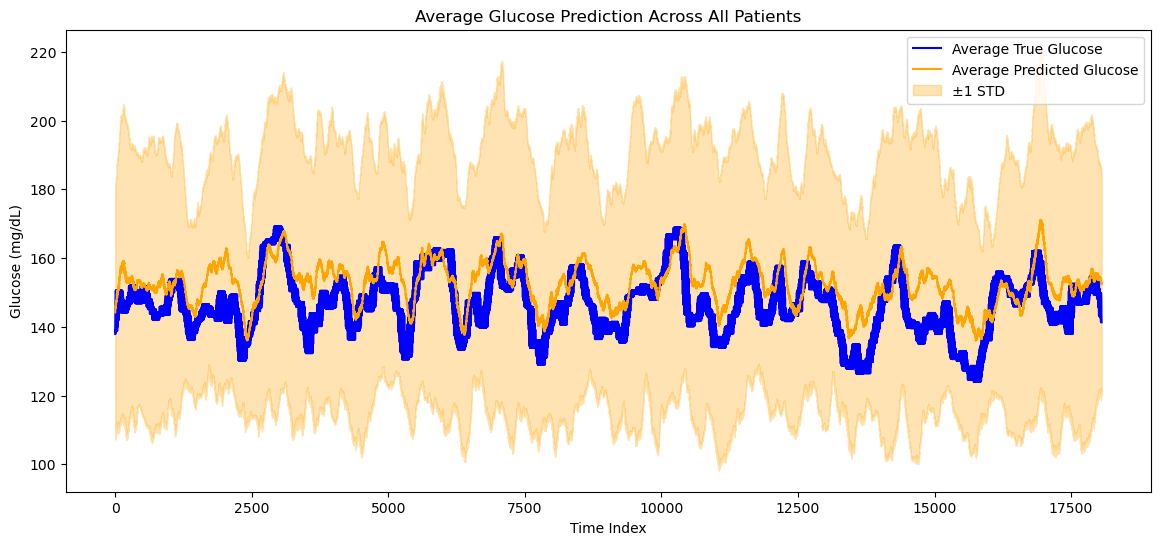

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

out_dir = "./glimmer_cnn_lstm_results"  # folder containing patient results

all_preds = []
all_truths = []

# Loop through each patient folder
for pid in os.listdir(out_dir):
    pred_file = os.path.join(out_dir, pid, "errors", "predictions.csv")
    if os.path.exists(pred_file):
        df_pred = pd.read_csv(pred_file)
        all_preds.append(df_pred['y_pred'].values)
        all_truths.append(df_pred['y_true'].values)

# Make sure all arrays are same length
min_len = min([len(p) for p in all_preds])
all_preds = np.array([p[:min_len] for p in all_preds])
all_truths = np.array([t[:min_len] for t in all_truths])

# Compute average
avg_pred = np.mean(all_preds, axis=0)
avg_true = np.mean(all_truths, axis=0)
std_pred = np.std(all_preds, axis=0)

# Plot
plt.figure(figsize=(14,6))
plt.plot(avg_true, label="Average True Glucose", color="blue")
plt.plot(avg_pred, label="Average Predicted Glucose", color="orange")
plt.fill_between(range(len(avg_pred)),
                 avg_pred - std_pred,
                 avg_pred + std_pred,
                 color='orange', alpha=0.3, label="±1 STD")
plt.xlabel("Time Index")
plt.ylabel("Glucose (mg/dL)")
plt.title("Average Glucose Prediction Across All Patients")
plt.legend()
plt.show()
